# Hotel Recognition to Combat Human Trafficking | Exploratory Data Analysis
    2021-04-05
    Edward Sims

## Introduction
Victims of human trafficking are often photographed in hotel rooms as in the below examples. Identifying these hotels is vital to these trafficking investigations but poses particular challenges due to low quality of images and uncommon camera angles.

![Image from Kaggle competition page: https://www.kaggle.com/c/hotel-id-2021-fgvc8/overview/description](images/example_victim_images.png)

Even without victims in the images, hotel identification in general is a challenging fine-grained visual recognition task with a huge number of classes and potentially high intraclass and low interclass variation. In order to support research into this challenging task and create image search tools for human trafficking investigators, we created the TraffickCam mobile application, which allows every day travelers to submit photos of their hotel room. Read more about [TraffickCam on TechCrunch](https://techcrunch.com/2016/06/25/traffickcam/).

## Evaluation
Submissions are evaluated according to the Mean Average Precision @ 5 (MAP@5):

<img src="images/map5_formula.png" alt="MAP@5 formula" style="width: 300px;"/>

where ***U*** is the number of images, ***P(k)*** is the precision at cutoff ***k***, ***n*** is the number of predictions per image, and ***rel(k)*** is an indicator function equaling 1 if the item at rank ***k*** is a relevant correct label, zero otherwise.

Once a correct label has been scored for an observation, that label is no longer considered relevant for that observation, and additional predictions of that label are skipped in the calculation. For example, if the correct label is ***A*** for an observation, the following predictions all score an average precision of 1.0.

```
A B C D E
A A A A A
A B A C A
```

## Submission File
For each image in the test set, you must predict a space-delimited list of hotel IDs that could match that image. The list should be sorted such that the first ID is considered the most relevant one and the last the least relevant one. The file should contain a header and have the following format:

```
image,hotel_id 
99e91ad5f2870678.jpg,36363 53586 18807 64314 60181
b5cc62ab665591a9.jpg,36363 53586 18807 64314 60181
d5664a972d5a644b.jpg,36363 53586 18807 64314 60181
```

## Data 
Identifying the location of a hotel room is a challenging problem of great interest for combating human trafficking. This competition provides a rich dataset of photos of hotel room interiors, without any people present, for this purpose.

Many of the hotels are independent or part of very small chains, where shared decor isn't a concern. However, the shared standards for their interior decoration for the larger chains means that many hotels can look quite similar at first glance. Identifying the chain can narrow the range of possibilities, but only down to a set that is much harder to tell apart and is still scattered across a wide geographic area. The real value lies in getting the number of candidates to a small enough number that a human investigator could follow up on all of them.

### Files
**train.csv** - The training set metadata.
 - `image` - The image ID.
 - `chain` - An ID code for the hotel chain. A chain of zero (0) indicates that the hotel is either not part of a chain or the chain is not known. This field is not available for the test set. The number of hotels per chain varies widely.
 - `hotel_id` - The hotel ID. The target class.
 - `timestamp` - When the image was taken. Provided for the training set only.
 
**sample_submission.csv** - A sample submission file in the correct format.
 - `image` The image ID
 - `hotel_id` The hotel ID. The target class.
 
**train_images** - The training set contains 97000+ images from around 7700 hotels from across the globe. All of the images for each hotel chain are in a dedicated subfolder for that chain.

**test_images** - The test set images. This competition has a hidden test set: only three images are provided here as samples while the remaining 13,000 images will be available to your notebook once it is submitted.

## 1.00 Import Packages

In [73]:
# Data manipulation packages
import pandas as pd
import numpy as np
import cv2

# General packages
import os
import gc
import random
from tqdm import tqdm, tqdm_notebook
import time
import warnings

# Data vis packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Package options
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 50)
plt.rcParams["figure.figsize"] = [14, 8]

## 2.00 Read in data
### 2.01 Get paths and set initial parameters

In [2]:
# Data paths
data_dir_path         = "../input/hotel-id-2021-fgvc8"
train_images_dir_path = os.path.join(data_dir_path, "train_images")
test_images_dir_path  = os.path.join(data_dir_path, "test_images")

train_metadata_path   = os.path.join(data_dir_path, "train.csv")
sample_sub_path       = os.path.join(data_dir_path, "sample_submission.csv")

# Read csv data
train_metadata        = pd.read_csv(train_metadata_path, parse_dates=["timestamp"])
sample_sub            = pd.read_csv(sample_sub_path)

In [3]:
# Set image parameters
ROWS     = 256 # Default row size
COLS     = 256 # Default col size
CHANNELS = 3

### 2.02 Read in images

In [4]:
def read_jpgs(image_dir_path, rows, cols, loading_bar=True):
    """Reads images into np.array from directory of image files.

    Parameters
    ----------
    image_dir : list
        Directory of images to read from.
    rows : int
        Image height to resize to.
    cols : int
        Image width to resize to.
    loading_bar : bool
        Include loading bar or non-verbose.

    Returns
    -------
    np.array
        Array of images read in.

    """
    # Read image data
    image_list = []
    
    if loading_bar == True:
        for chain_id in tqdm(os.listdir(image_dir_path)):
            # Each subdirectory is a chain_id
            chain_id_dir_path = os.path.join(image_dir_path, chain_id)
            # Read images from each chain_id subdirectory
            for image in os.listdir(chain_id_dir_path)[0:10]: # Read only first 10 images for eda
                # Read image
                image_path = os.path.join(chain_id_dir_path, image)
                try:
                    image = cv2.imread(image_path)
                    image = cv2.resize(image, (rows, cols))
                    # Append to list of images
                    image_list.append(image)    
                except:
                    pass
    elif loading_bar == False:
        for chain_id in os.listdir(image_dir_path):
            # Each subdirectory is a chain_id
            chain_id_dir_path = os.path.join(image_dir_path, chain_id)
            # Read images from each chain_id subdirectory
            for image in os.listdir(chain_id_dir_path):
                # Read image
                image_path = os.path.join(chain_id_dir_path, image)
                try:
                    image = cv2.imread(image_path)
                    image = cv2.resize(image, (rows, cols))
                    # Append to list of images
                    image_list.append(image)    
                except:
                    pass
    
    # Convert image list to array
    image_list = np.array(image_list)
    
    return(image_list)

In [5]:
#train_images = read_jpgs(image_dir_path=train_images_dir_path, rows=ROWS, cols=COLS)

## 3.00 Metadata Analysis

TODO:
 - Aggregations
  - Freq chain - distplot
  - Freq hotel id
  - Avg/max/min/std number of ids per chain
  - Avg/max/min/std number of ids per hotel id
  
 - Time stamps
  - Range of dates
  - Freq years
  - Freq month
  - Freq weekend
  - Distplot dates per year (month and day freqs)
  - Distplot times (24hrs)

### 3.01 Initial Checks

In [6]:
train_metadata.head()

,image,chain,hotel_id,timestamp
0,8000d59f6a3d765f.jpg,85,24607,2018-11-28 05:42:31
1,8000febe81817f7f.jpg,6,25389,2017-01-01 07:01:46
2,80053befc2d42fba.jpg,3,672,2018-01-26 13:22:07
3,8007fa0a8fe89f9d.jpg,5,63866,2020-07-03 02:31:31
4,800a4a6b6f6d2df6.jpg,0,12036,2017-09-22 17:59:22


In [7]:
train_metadata.tail()

,image,chain,hotel_id,timestamp
97551,ffff8082ec219892.jpg,83,20544,2016-12-18 03:04:54
97552,ffff8200e50cc0f1.jpg,82,51053,2018-01-23 03:51:42
97553,ffff84129981a4a4.jpg,83,42842,2017-03-30 22:45:24
97554,ffff85015040c2af.jpg,82,6261,2016-11-09 12:34:06
97555,ffffc0c05f2820c1.jpg,79,58764,2017-06-14 21:55:37


In [8]:
train_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97556 entries, 0 to 97555
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   image      97556 non-null  object        
 1   chain      97556 non-null  int64         
 2   hotel_id   97556 non-null  int64         
 3   timestamp  97556 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 3.0+ MB


### 3.02 Duplicates

In [9]:
# Print high level stats on metadata dimensions
print(f"Train metadata dimensions: \t{train_metadata.shape}")
print(f"Number of unique records: \t{len(train_metadata.drop_duplicates())}")
print(f"Number of unique image names: \t{train_metadata['image'].nunique()}")

Train metadata dimensions: 	(97556, 4)
Number of unique records: 	97556
Number of unique image names: 	97554


There appear to be two duplicated image names, but these aren't considered duplicate records. We'll investigate these two records individually.

In [10]:
# Subset duplicated image names - to all records (not just duplicates)
train_metadata.loc[train_metadata.groupby("image")["image"].transform("count") > 1, ]

,image,chain,hotel_id,timestamp
56845,c7c7383898d76598.jpg,6,60918,2020-07-18 00:03:38
56846,c7c7383898d76598.jpg,6,60918,2020-08-29 04:35:13
62238,ce27d36c9147cc19.jpg,6,60918,2020-07-18 00:03:38
62239,ce27d36c9147cc19.jpg,6,60918,2020-08-29 04:35:13


It looks like these records have indeed been duplicated, and the names have just been switched around. We can remove 1 of each record. 

Although 2 records don't seem like a lot in the grand scheme of things (i.e. out of 97,554 total records), but every marginal improvement in the data quality is **critical** to model improvement. 

In [44]:
# Remove 2 duplicated records
train_metadata_dupes = train_metadata.loc[train_metadata.groupby("image")["image"].transform("count") > 1, ]
train_metadata_dupes_idx = train_metadata_dupes.iloc[[1, 3]].index
train_metadata = train_metadata.drop(train_metadata_dupes_idx, axis=0)

del train_metadata_dupes, train_metadata_dupes_idx

In [56]:
# Observe any duplicates using chain, hotel_id and timestamp columns
train_metadata[train_metadata.duplicated(
    subset=["chain", "hotel_id", "timestamp"], keep=False
)].sort_values(["chain", "hotel_id", "timestamp"])

,image,chain,hotel_id,timestamp
4193,8597c66e7391994c.jpg,0,204,2016-11-11 20:47:06
6184,87b5cbc0cc9cd8cc.jpg,0,204,2016-11-11 20:47:06
15175,93964ced92cc29b6.jpg,0,204,2016-11-11 20:47:06
71157,d89c8f0f70b0686f.jpg,0,204,2016-11-11 20:47:06
37149,adec21fa1b609a65.jpg,0,204,2017-10-08 20:59:29
...,...,...,...,...
92514,f8fc07c39748c1b4.jpg,91,47164,2016-06-28 17:08:15
65887,d2472a50cf35cd3a.jpg,91,47164,2019-09-23 19:16:34
70709,d7d478cfcb046381.jpg,91,47164,2019-09-23 19:16:34
72056,d9b39a56e25ca861.jpg,91,47164,2019-09-23 19:16:34


Excluding the image column, most images are considered duplicates - this won't actually be the case however. Rather, it can possibly be that the timestamp column is not wholly accurate. Images may have been batch uploaded, or the timestamp column doesn't precisely measure the actual time these images were taken. 

The timestamp feature will be analysed in more detail to see if there is any value in including this feature as part of our model training. While it is not included as a feature in the test set, if informative, we can use it in our cross validation strategy. 

And as for possible image duplicates (where the metadata appear unique, but the actual image isn't), this will also be analysed in subsequent sections.

## 3.03 Chain Analysis

In [59]:
print(f"Number of unique chain ids: {train_metadata['chain'].nunique()}")

Number of unique chain ids: 88


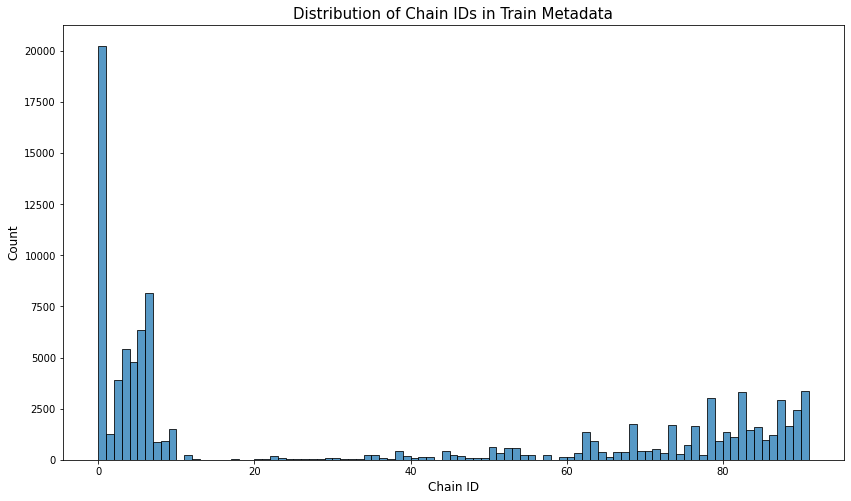

In [96]:
# Plot histogram of chain ids
sns.histplot(data=train_metadata, x="chain", stat="count", binwidth=1)
plt.xlabel("Chain ID", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Distribution of Chain IDs in Train Metadata", fontsize=15)
plt.show()

We'll definitely have to stratify by chain during cross validation - there's a heavy 'skew' (there's no particular distribution) towards lower chain ID integers, as well as some increase in counts towards the higher end of chain ID integers also. The middle range appears quite sparse, so we should take extra care not to allow our model to favour only chain IDs in the majority groups.

In [124]:
# Display descriptive stats on numbers of records per chain id
train_chain_stats = pd.DataFrame(train_metadata["chain"].value_counts())
train_chain_stats.describe().rename(columns={"chain": "Chain ID Count Statistics"})

,Chain ID Count Statistics
count,88.000000
mean,1108.568182
std,2528.773719
min,8.000000
25%,80.750000
50%,262.500000
75%,1144.500000
max,20259.000000
